## EDA

- Wikipedia comments on toxic comments

### Import Packages

In [ ]:
import pandas as pd
import numpy as np

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
nltk.download('stopwords')
import keras
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from google.colab import drive

from collections import Counter
import re
import string

!pip install transformers
from transformers import BartTokenizer, TFBartForConditionalGeneration
from pprint import pprint

!pip install better_profanity
from better_profanity import profanity

pd.set_option("display.max_rows", None, # display all rows
              "display.max_columns", None, # display all columns
              "display.max_colwidth", None, # expand column width
              "display.html.use_mathjax", False) # disable Latex style mathjax rendering

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.3 MB/s 
     |████████████████████████████████| 101 kB 2.6 MB/s 
     |████████████████████████████████| 596 kB 42.1 MB/s 
     |████████████████████████████████| 6.6 MB 36.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 322 kB/s 


### Mount Drive

In [ ]:
drive.mount('/drive') 
%cd /drive/MyDrive/W266 Project/Colab Notebooks/Exploration
!pwd

Mounted at /drive
/drive/.shortcut-targets-by-id/1p1bDkEjmNKPzX456WZWBr8qtvPr6Pt5m/W266 Project/Colab Notebooks/Exploration
/drive/.shortcut-targets-by-id/1p1bDkEjmNKPzX456WZWBr8qtvPr6Pt5m/W266 Project/Colab Notebooks/Exploration


### Import Data
Data downloaded from [kaggle link](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview) to drive

In [ ]:
train_raw = pd.read_csv('../../data/jigsaw-toxic-comment-classification-challenge/train.csv').set_index('id')
test_raw = pd.read_csv('../../data/jigsaw-toxic-comment-classification-challenge/test.csv').set_index('id')
test_labels = pd.read_csv('../../data/jigsaw-toxic-comment-classification-challenge/test_labels.csv').set_index('id')
test_raw = test_raw.join(test_labels)

### Inspect Data



#### Missing Data

In [ ]:
train_raw.isna().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

#### Data Shape + Summary

In [ ]:
print(f'{train_raw.shape[0]} records and {train_raw.shape[1]} features')

159571 records and 7 features


In [ ]:
train_raw.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [ ]:
train_raw.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The test data, however, does not take on only 0 or 1 values. it takes values of -1, 0, or 1. Values of -1 indicate a comment is not used for scoring, and the label type is lost. Therefore, we will remove any data where all column values are -1. 

In [ ]:
test_raw.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000
mean,-0.542530,-0.579895,-0.558193,-0.580913,-0.559916,-0.577642
std,0.572465,0.498408,0.542966,0.496195,0.539594,0.503260
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Note: Wherever a value is -1, all other column values take on -1. Which is over half of 'test'

In [ ]:
test_labels.value_counts().head()

toxic  severe_toxic  obscene  threat  insult  identity_hate
-1     -1            -1       -1      -1      -1               89186
 0      0             0        0       0       0               57735
 1      0             1        0       1       0                1932
                      0        0       0       0                1710
                      1        0       0       0                 854
dtype: int64

Reducing test_raw down to usable values

In [ ]:
test_raw = test_raw[test_raw['toxic'] >= 0].copy()

#### Correlation Matrix

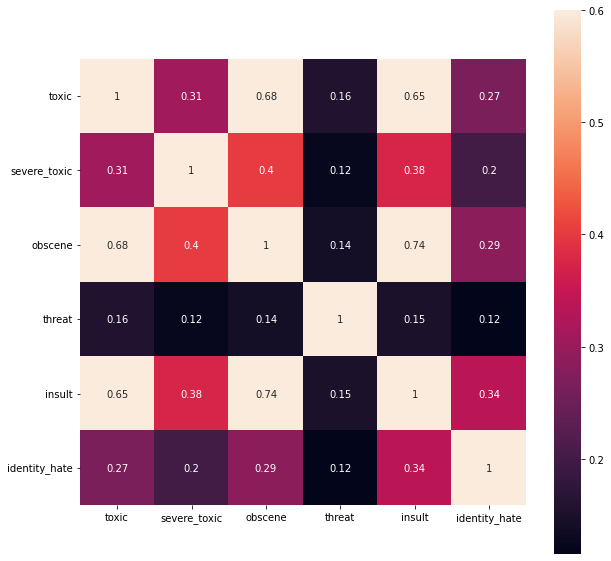

In [ ]:
plt.figure(figsize = [10, 10])
targets = list(train_raw.columns[1:])
corr_plot = train_raw[targets].corr()
sns.heatmap(corr_plot, vmax=0.6, square=True, annot=True)
plt.yticks(rotation = 360)
plt.show()

#### Comment Type Breakdown

Now that test and train have the same form, we can inspect some of the data.

First, we can see that the data is incredibly unbalanced, with the majority of cases appearing with label of 0. 

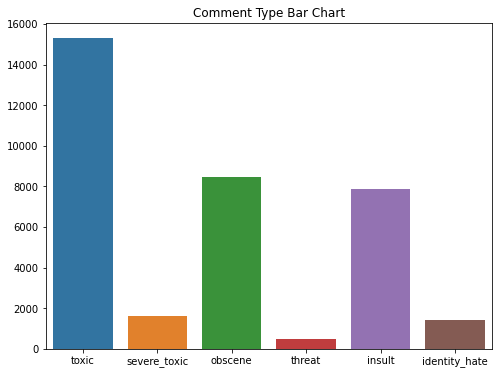

toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0                143346
1      0             0        0       0       0                  5666
                     1        0       1       0                  3800
                                      0       0                  1758
                     0        0       1       0                  1215
       1             1        0       1       0                   989
       0             1        0       1       1                   618
0      0             1        0       0       0                   317
                     0        0       1       0                   301
1      1             1        0       1       1                   265
0      0             1        0       1       0                   181
1      1             1        0       0       0                   158
       0             0        0       0       1                   136
                              

In [ ]:
df = train_raw[targets].copy()
count_dict = {}
for commentType in targets:
    other = list(targets)
    count = list()
    df_selection = df[(df[commentType] == 1)]
    other.remove(commentType)
    count.append(('total', len(df_selection)))
    for i in other:
        count.append((i, df_selection[i].sum()))
    count_dict[commentType] = count

totals = [v[0][1] for k, v in count_dict.items()]
    
plt.figure(figsize=[8, 6])
plt.title('Comment Type Bar Chart')
sns.barplot(x = list(count_dict.keys()), y = totals)
plt.show()

train_raw[['toxic', 'severe_toxic', 'obscene', 
           'threat', 'insult', 'identity_hate']].value_counts()

This is partially misleading, though, as we don't expect all rows to be filled with 1's. This pseudo-one-hot-encoded structure is also not ideal for our models, so we will essentially pivot it to have one binary column, where we classify a comment as a threat (1) or non-threatening (0)

This is done with the label_violent function, and is generic enough to be used for test and train

#### Display Comments

In [ ]:
lineBreak = '-' * 100
commentBreak = '*' * 100
num = 5

for target in targets:
  print(f'\n{lineBreak}\nCategory: {target}\n{lineBreak}')
  viol = np.where(df[target]==1)[0]
  rand_Vcomments = np.random.choice(viol, num)
  for r in rand_Vcomments:
    print(train_raw.reset_index().comment_text.loc[r])
    print(commentBreak)


----------------------------------------------------------------------------------------------------
Category: toxic
----------------------------------------------------------------------------------------------------
Leave me alone shut up you low life loser and do not write to me  Ilovedirtbikes
****************************************************************************************************
F**** and Happy New Year to you too. Have been busy doing some renovation and not too much time to deal with you guys. Still left with approx 200 unused IP addresses , good for almost a year to have a good laugh with you and make some serious contributions.
By the way have you noticed that wikipedia sucks and nobody is taking it seriously nowadays. It is good as a children's games though.
Just found out a reference that Ali Pasha Tepelena had a preference for young greek boys, so will have to leave and update tha right page. See ya soon. Wikipedia sucks!
**************************************

#### Concatenate Multilabels

In [ ]:
def label_violent(df, violent_types):
    
    # Set the list of types to consider violent
    condition = ' == 1 | '.join(violent_types) + ' == 1'
    violent_inds = df.query(condition).index    # indices for violent = 1
    non_violent_inds = df.index.difference(violent_inds)    # indices for violent = 0

    # isolate violent and non-violent data
    violent = df.loc[violent_inds]
    violent['violent'] = 1
    non_violent = df.loc[non_violent_inds]
    non_violent['violent'] = 0

    # Stack violent and non-violent sub dfs
    df = pd.concat([violent, non_violent], axis = 0)
    
    # Return df with only comment text and violent = 1 or 0
    return df[['comment_text', 'violent']]

In [ ]:
violent_cats = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train = label_violent(train_raw, violent_cats)
test = label_violent(test_raw, violent_cats)

Now we can see there is a slightly lesser gap between 0 and 1

In [ ]:
train['violent'].value_counts()

0    143346
1     16225
Name: violent, dtype: int64

#### Frequent Words

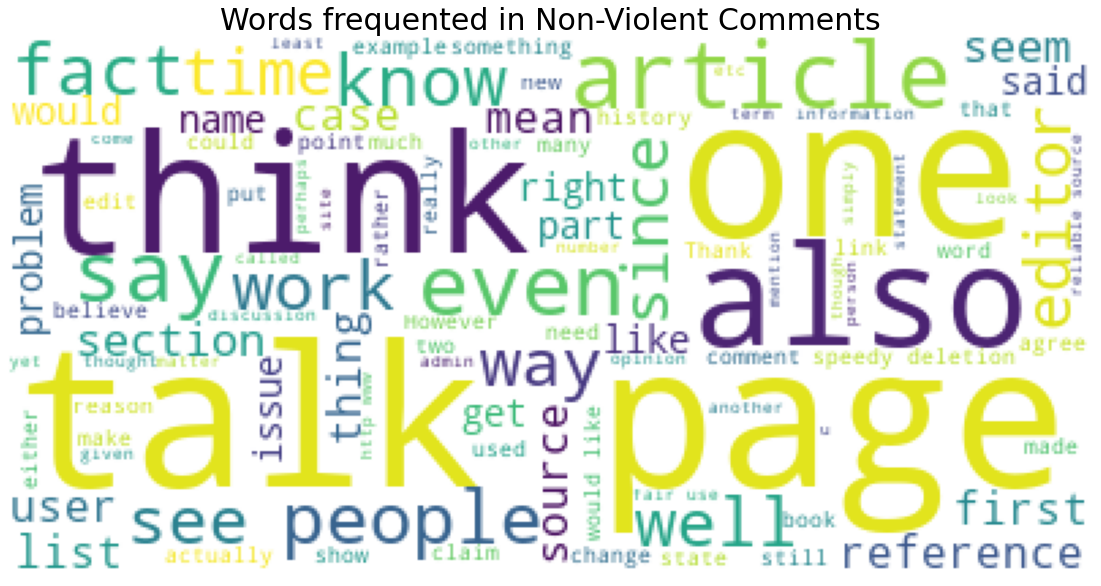

In [ ]:
# non-violent comments
subset = train[train.violent == False]
text = subset.comment_text.values
wc = WordCloud(background_color='white', max_words=100,
              stopwords=set(stopwords.words('english')))
wc.generate(' '.join(text))
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title('Words frequented in Non-Violent Comments', fontsize = 30)
plt.imshow(wc.recolor(colormap = 'viridis' ,random_state = 2), alpha = 0.98)
plt.show()

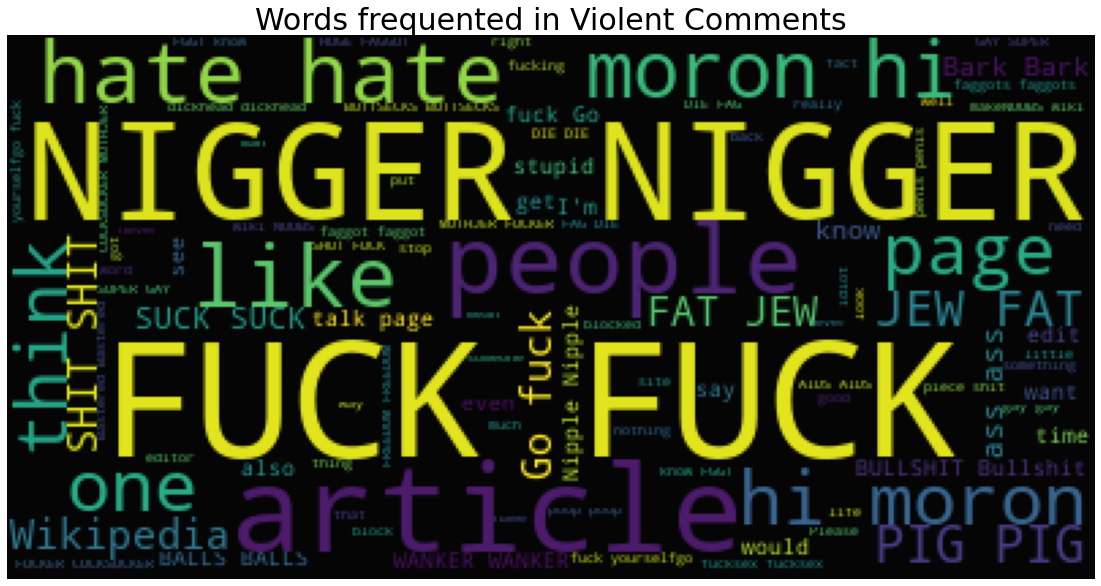

In [ ]:
# violent comments
subset = train[train.violent == True]
text = subset.comment_text.values
wc = WordCloud(background_color='black', max_words=100,
              stopwords=set(stopwords.words('english')))
wc.generate(' '.join(text))
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title('Words frequented in Violent Comments', fontsize = 30)
plt.imshow(wc.recolor(colormap = 'viridis' ,random_state = 2), alpha = 0.98)
plt.show()

In [ ]:
train.to_csv('../../data/transformed/train.csv')
test.to_csv('../../data/transformed/test.csv')

### Load Data with Binary Labels

In [ ]:
train = pd.read_csv('../../data/transformed/train.csv').set_index('id')
test = pd.read_csv('../../data/transformed/test.csv').set_index('id')

In [ ]:
train.head()

,violent,comment_text_transf
0,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
1,1,"Hey what is it.. talk . What is it an exclusive group of some WP TALIBANS who are good at destroying, self appointed purist who GANG UP any one who asks them questions abt their ANTI SOCIAL and DESTRUCTIVE non contribution at WP? Ask Sityush to clean up his behavior than issue me nonsensical warnings"
2,1,"Bye! Don't look, come or think of comming back! Tosser."
3,1,"You are gay or antisemmitian? Archangel WHite Tiger Meow! Greetingshhh! Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone 1 If you are anti semitian, than shave your head bald and go to the skinhead meetings! 2 If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals! 3 First and last warning, you fucking gay I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore! Beware of the Dark Side!"
4,1,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!"


#### Data Transformation

In [ ]:
def comment_transforms(comment_string, phase = 0):
  if phase == 0:
      comment_string = re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}',' ', comment_string)
    
  elif phase == 1:
      comment_string = str.lower(comment_string)
      comment_string = comment_string.replace('{','')\
                                      .replace('}','')\
                                      .replace('>','')\
                                      .replace('<','')\
                                      .replace('?','.')\
                                      .replace('-',' ')\
                                      .replace('...',' ')\
                                      .replace('\n',' ')\
                                      .replace(':','')\
                                      .replace('"','')\
                                      .replace('!','')
  elif phase == 2:   
      comment_string = str.lower(comment_string)
      comment_string = comment_string.replace('{','')\
                                      .replace('}','')\
                                      .replace('>','')\
                                      .replace('<','')\
                                      .replace('?','.')\
                                      .replace('-',' ')\
                                      .replace('...',' ')\
                                      .replace('\n',' ')\
                                      .replace(':','')\
                                      .replace('"','')\
                                      .replace('[','')\
                                      .replace(']','')\
                                      .replace('*','')\
                                      .replace('\t',' ')\
                                      .replace('\\','')\
                                      .replace('\/','')\
                                      .replace('=','')\
                                      .replace('@','')\
                                      .replace('(','')\
                                      .replace(')','')\
                                      .replace('|','')\
                                
      # remove sensitive info such as IP, username
      comment_string = re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}',' ', comment_string)
      comment_string = re.sub('\[\[.*\]','', comment_string)
      comment_string = re.sub(' +', ' ', comment_string)
      comment_string = re.sub('-+', ' ', comment_string)
      comment_string = re.sub('\.+', '.', comment_string)
      comment_string = re.sub('\^+', ' ', comment_string)
  
  elif phase == 3:  
      comment_string = comment_string.replace('{','')\
                                      .replace('}','')\
                                      .replace('>','')\
                                      .replace('<','')\
                                      .replace('-',' ')\
                                      .replace('...',' ')\
                                      .replace('\n',' ')\
                                      .replace(':','')\
                                      .replace('"','')\
                                      .replace('[','')\
                                      .replace(']','')\
                                      .replace('*','')\
                                      .replace('\t',' ')\
                                      .replace('\\','')\
                                      .replace('\/','')\
                                      .replace('=','')\
                                      .replace('@','')\
                                      .replace('(','')\
                                      .replace(')','')\
                                      .replace('|','')\
                                
      # remove sensitive info such as IP, username
      comment_string = re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}',' ', comment_string)

  elif phase == 4:
      comment_string = comment_string.replace('{','')\
                                      .replace('}','')\
                                      .replace('>','')\
                                      .replace('<','')\
                                      .replace('-',' ')\
                                      .replace('...',' ')\
                                      .replace('\n',' ')\
                                      .replace(':','')\
                                      .replace('"','')\
                                      .replace('[','')\
                                      .replace(']','')\
                                      .replace('*','')\
                                      .replace('\t',' ')\
                                      .replace('\\','')\
                                      .replace('\/','')\
                                      .replace('=','')\
                                      .replace('@','')\
                                      .replace('(','')\
                                      .replace(')','')\
                                      .replace('|','')\

  return comment_string

train['comment_text_transf'] = train['comment_text'].apply(comment_transforms)
test['comment_text_transf'] = test['comment_text'].apply(comment_transforms)

In [ ]:
train.head()

,comment_text,violent,comment_text_transf
id,,,
0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
0005c987bdfc9d4b,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings..."
0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1,"Bye! \n\nDon't look, come or think of comming back! Tosser."
001810bf8c45bf5f,"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!",1,"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!"
00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!"


#### Display Transformed Comments

In [ ]:
lineBreak = '-' * 100
commentBreak = '*' * 100
num = 10

for target in ['violent']:
  print(f'\n{lineBreak}\nCategory: {target}\n{lineBreak}')
  viol = np.where(train['violent']==1)[0]
  rand_Vcomments = np.random.choice(viol, num)
  for r in rand_Vcomments:
    print(train.reset_index().comment_text_transf.loc[r])
    print(commentBreak)


----------------------------------------------------------------------------------------------------
Category: violent
----------------------------------------------------------------------------------------------------
Spare us  Instead of inserting idiotic comments about subjects you clearly know nothing about, why not try doing a simple Google search first. e.g. http//www.google.com/search?hlen&safe;off&q;%22thomas+cannon%22+homosexuality&btnG;Search But that would imply self doubt, wouldn't it. And be so tiresome. And so unnecessary for someone who has, what, a Barnstar? Never mind your laziness or stupidity I spit on your arrogance.
****************************************************************************************************
   Helly Jimmy, well; fuck you.   According to Wikipedia talkNo legal threats; people shouldn't say to one another what you do is supporting terrorism, and you should be judged front of law.  On the other hand, we can say fuck you and the punishment fo

#### BART - Summarize Comments

In [ ]:
model = TFBartForConditionalGeneration.from_pretrained("facebook/bart-large")
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
inputs = tokenizer(train.comment_text_transf.tolist()[-1], max_length=1024, truncation=True, return_tensors="tf")
summary_ids = model.generate(inputs["input_ids"],
    num_beams=10,
    no_repeat_ngram_size=1,
    min_length=10,
    max_length=50)                              
print(f'\nOriginal Comment:')
pprint([train.comment_text_transf.tolist()[-1]])
print(f'\nBART Comment Summary:')
pprint(tokenizer.batch_decode(summary_ids, skip_special_tokens=True, 
                              clean_up_tokenization_spaces=False), compact=True)

Downloading:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]


Original Comment:
["   interesting page   There's some good info here, but as Calum says, there "
 'are also some errors here.  By the Right Quick March The Pipe Majordirects '
 'the band with words that express the tempo   Right Quick March.  A right '
 "quick march doesn't exist.  The Drum Major directs the band to play a quick "
 'march, yes, but the phrase by the right is not related to the tempo.  This '
 'tells the band which file in this case, the right file to take their '
 'dressing from.  The right is usually the side the pipe major is on, either '
 'on his own, or as the right hand person in the front rank.  You often hear '
 'by the centre as well, with by the left being far less common.']

BART Comment Summary:
['The Pipe Majordirects the band with words that express their tempo.  The '
 "right quick march doesn't exist, it's just a phrase to be used when you're "
 'marching in front of your drum major or other pipemaster']


#### Comment Length

In [ ]:
train['length'] = train.comment_text_transf.apply(lambda x: len(x))
test['length'] = test.comment_text_transf.apply(lambda x: len(x))
print(
    f'''
Average Violent Comment Length: {int(np.mean(train[(train.violent == 1)].length))}
Average Non-Violent Comment Length: {int(np.mean(train[(train.violent == 0)].length))}

Median Violent Comment Length: {int(np.median(train[(train.violent == 1)].length))}
Median Non-Violent Comment Length: {int(np.median(train[(train.violent == 0)].length))}
    '''
)


Average Violent Comment Length: 300
Average Non-Violent Comment Length: 399

Median Violent Comment Length: 127
Median Non-Violent Comment Length: 213
    


#### Capitalization, Exclamation and Question Marks

In [ ]:
def caps_pct(x):
    return sum([1 for c in x if c.isupper()]) / (sum(([1 for c in x if c.isalpha()])) + 1)
train['caps'] = train.comment_text_transf.apply(lambda x: caps_pct(x))
test['caps'] = test.comment_text_transf.apply(lambda x: caps_pct(x))

train['exclamation'] = train.comment_text_transf.apply(lambda x: len([c for c in x if c == '!']))
test['exclamation'] = test.comment_text_transf.apply(lambda x: len([c for c in x if c == '!']))

train['qmark'] = train.comment_text_transf.apply(lambda x: len([c for c in x if c == '?']))
test['qmark'] = test.comment_text_transf.apply(lambda x: len([c for c in x if c == '?']))

print(
    f'''
Percent Average Violent Comment Capitalized: {int(np.mean(train[(train.violent == 1)].caps) * 100)}%
Percent Average Non-Violent Comment Capitalized: {int(np.mean(train[(train.violent == 0)].caps) * 100)}%

Average Number of Exclamation Marks in Violent Comment: {np.mean(train[(train.violent == 1)].exclamation):.2f}
Average Number of Exclamation Marks in Non-Violent Comment: {np.mean(train[(train.violent == 0)].exclamation):.2f}

Average Number of Question Marks in Violent Comment: {np.mean(train[(train.violent == 1)].qmark):.2f}
Average Number of Question Marks in Non-Violent Comment: {np.mean(train[(train.violent == 0)].qmark):.2f}
    '''
)


Percent Average Violent Comment Capitalized: 14%
Percent Average Non-Violent Comment Capitalized: 5%

Average Number of Exclamation Marks in Violent Comment: 3.47
Average Number of Exclamation Marks in Non-Violent Comment: 0.34

Average Number of Question Marks in Violent Comment: 0.59
Average Number of Question Marks in Non-Violent Comment: 0.43
    


#### Tokenize

In [ ]:
top_words = 5000
tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True, num_words=top_words)
tokenizer.fit_on_texts(train['comment_text_transf'])
train['sequence_comment'] = tokenizer.texts_to_sequences(train.comment_text_transf)

tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True, num_words=top_words)
tokenizer.fit_on_texts(test['comment_text_transf'])
test['sequence_comment'] = tokenizer.texts_to_sequences(test.comment_text_transf)

In [ ]:
display(train.comment_text_transf[5])
train.sequence_comment[5]

"I'm Sorry   I'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert your dominance over them.  I know I should bow down to the almighty administrators.  But then again, I'm going to go play outside .with your mom.   76.122.79.82"

[3,
 70,
 264,
 3,
 70,
 264,
 3,
 318,
 22,
 45,
 29,
 10,
 26,
 102,
 339,
 2,
 35,
 3,
 72,
 73,
 343,
 1,
 1087,
 15,
 92,
 45,
 29,
 1787,
 6,
 1709,
 21,
 153,
 89,
 3,
 72,
 3,
 59,
 330,
 2,
 1,
 972,
 28,
 83,
 127,
 3,
 70,
 171,
 2,
 121,
 812,
 942,
 22,
 21,
 3512,
 1736,
 3695,
 3166,
 2353]

#### Top Words

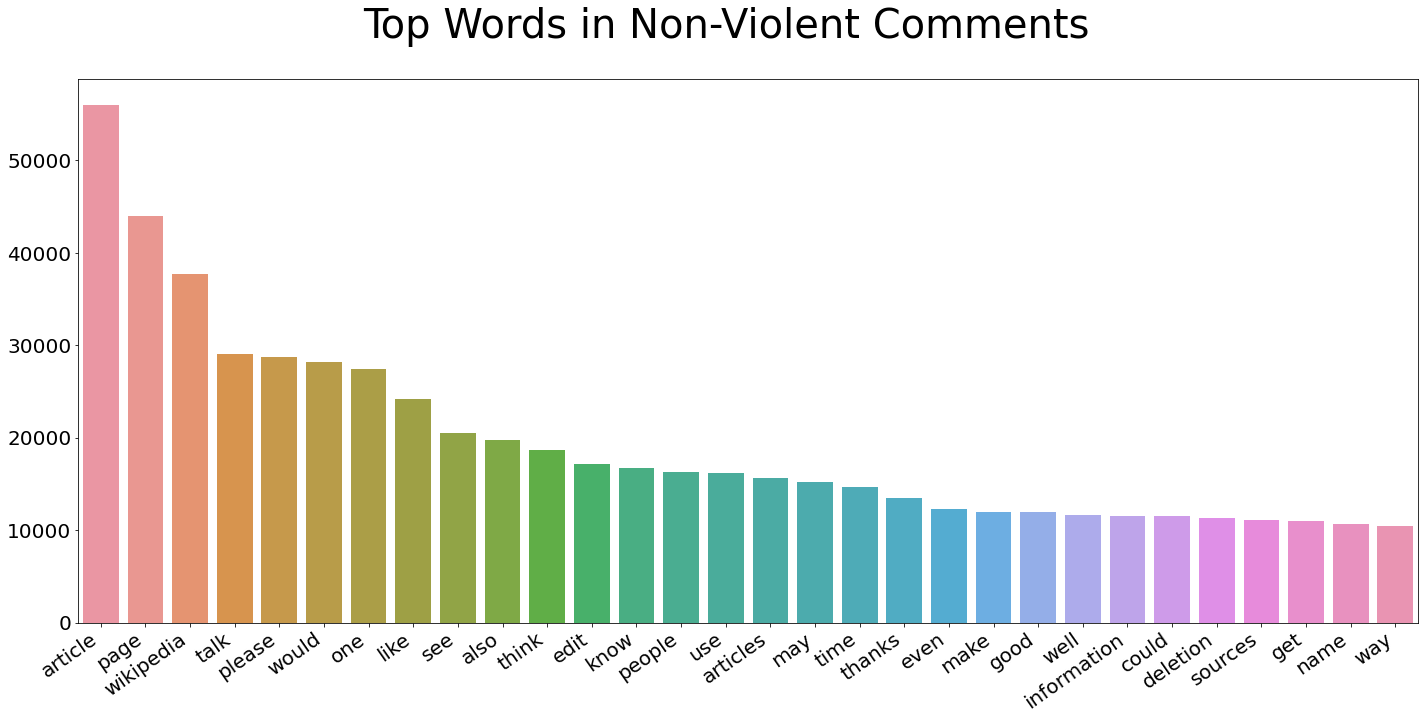

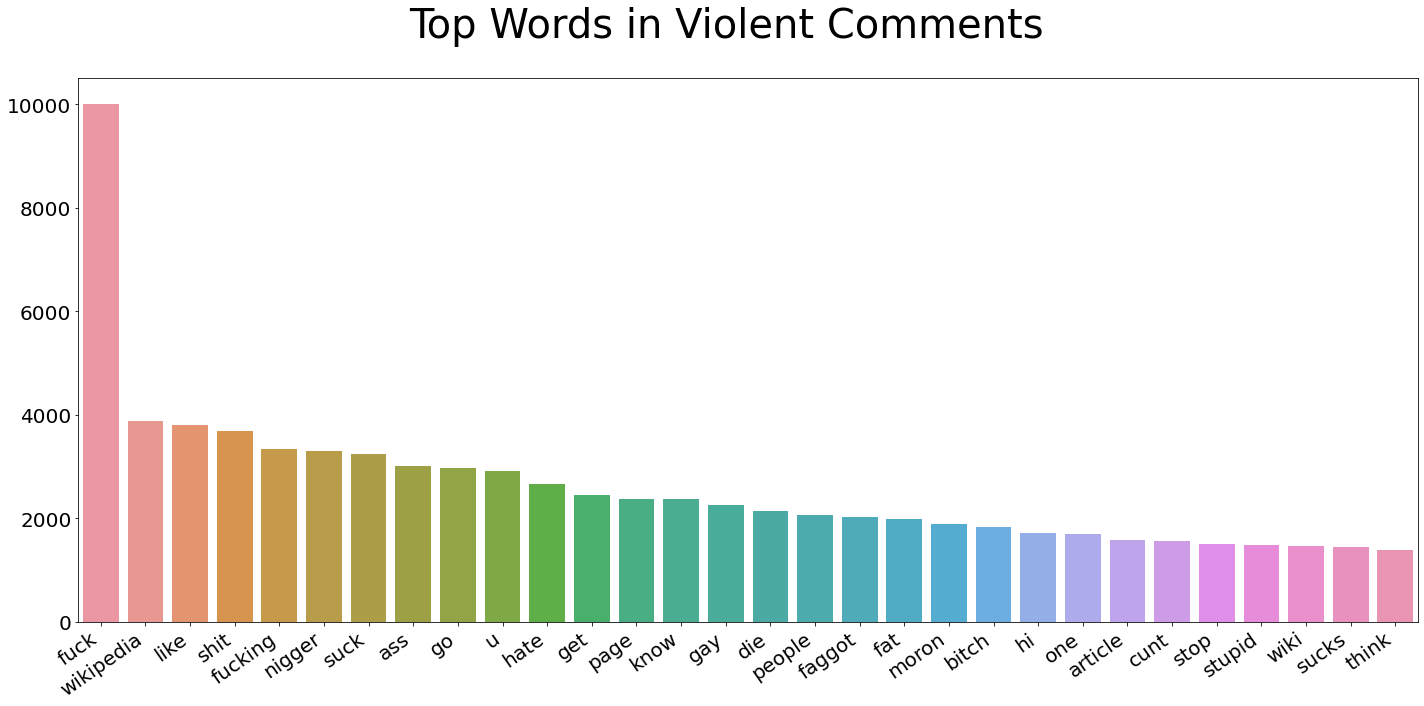

In [ ]:
def count_frequency(tokenizer):
    word_freq = [(k, v) for k, v in zip(tokenizer.word_counts.keys(), 
                                       tokenizer.word_counts.values())]
    word_freq.sort(key = lambda tup: tup[1], reverse=True)
    stop_words = set(stopwords.words('english'))
    word_freq = [tup for tup in word_freq if tup[0] not in stop_words]
    return word_freq

def top_words_chart(word_freq, num_words, title):
    plt.figure(title, figsize = (24, 10))
    plt.suptitle(title, fontsize = 40)
    sns.barplot(x = [tup[0] for tup in word_freq[0:num_words]], 
                y = [tup[1] for tup in word_freq[0:num_words]])
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20, rotation = 35, ha = 'right')
    plt.show()

nonviol_tokenizer = Tokenizer(filters = string.punctuation + '\n', lower=True)
nonviol_tokenizer.fit_on_texts(train.comment_text_transf[train.violent == 0])
top_words_chart(count_frequency(nonviol_tokenizer), 30, 'Top Words in Non-Violent Comments')

viol_tokenizer = Tokenizer(filters = string.punctuation + '\n', lower=True)
viol_tokenizer.fit_on_texts(train.comment_text_transf[train.violent == 1])
top_words_chart(count_frequency(viol_tokenizer), 30, 'Top Words in Violent Comments')

In [ ]:
train.drop(['comment_text'], axis=1).to_csv('../../data/transformed/final/train_base.csv', index=False)
test.drop(['comment_text'], axis=1).to_csv('../../data/transformed/final/test_base.csv', index=False)

In [ ]:
train.drop(['comment_text', 
            'length', 
            'caps',
            'exclamation',
            'qmark',
            'sequence_comment',
            ], axis=1).to_csv('../../data/transformed/final/train.csv', index=False)
test.drop(['comment_text', 
           'length', 
           'caps',
           'exclamation',
           'qmark',
           'sequence_comment',
           ], axis=1).to_csv('../../data/transformed/final/test.csv', index=False)